In [694]:
import pandas as pd
import requests
import time
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer,sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score

In [170]:
def get_submissions(subreddit, n_iter, epoch_right_now):
    base_url = 'https://api.pushshift.io/reddit/search/submission?subreddit='
    
    df_list = []
    
    current_time = epoch_right_now
    
    for post in range(n_iter):
        res = requests.get(base_url,params = {'subreddit':subreddit,'size':100, 'lang':100, 'before':current_time,'selftext:not':'[removed]','q:not':'[deleted]'})
    
        df = pd.DataFrame(res.json()['data'])
        
        df= df.loc[:, ['title','created_utc','selftext','subreddit','author','media_only','permalink']]
        
        df_list.append(df)
        
        time.sleep(5)
        
        current_time = df['created_utc'].min()
        
    return pd.concat(df_list, axis=0)

---
### get the data

In [215]:
# math_submissions = get_submissions('math',50,1617047153)

In [264]:
# math_submissions.to_csv('math_submissions.csv',index=False)

In [171]:
# physics_submissions = get_submissions('Physics',50,1617047153)

In [172]:
# physics_submissions.to_csv('physics_submissions.csv',index=False)

In [609]:
# # get removed posts
# def get_submissions_removed(subreddit, n_iter, epoch_right_now):
#     base_url = 'https://api.pushshift.io/reddit/search/submission?subreddit='
    
#     df_list = []
    
#     current_time = epoch_right_now
    
#     for post in range(n_iter):
#         res = requests.get(base_url,params = {'subreddit':subreddit,'size':100, 'lang':100, 'before':current_time,'selftext':'[removed]'})
    
#         df = pd.DataFrame(res.json()['data'])
        
#         df= df.loc[:, ['title','created_utc','selftext','subreddit','author','media_only','permalink']]
        
#         df_list.append(df)
        
#         time.sleep(5)
        
#         current_time = df['created_utc'].min()
        
#     return pd.concat(df_list, axis=0)

# math_submissions_removed =  get_submissions_removed('math',50,1617047153)

In [610]:
# math_submissions_removed.to_csv('math_submissions_removed.csv',index=False)

---

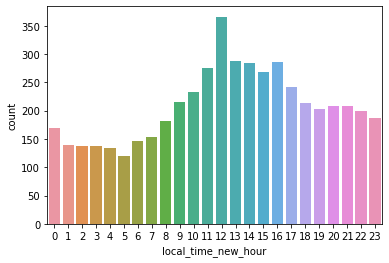

In [750]:
# math_submissions: convert utc time to local time and see the distribution of post based on hour
math_submissions = pd.read_csv('math_submissions.csv')
test_math_submissions = math_submissions.copy()
test_math_submissions['local_time_new'] = test_math_submissions['created_utc'].map(lambda x:datetime.fromtimestamp(x))
test_math_submissions['local_time_new_hour'] = test_math_submissions['created_utc'].map(lambda x:datetime.fromtimestamp(x).hour)
sns.countplot(test_math_submissions['local_time_new_hour']);

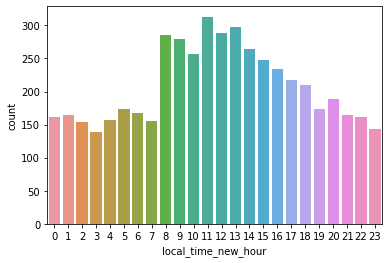

In [751]:
# physics_submissions: convert utc time to local time and see the distribution of post based on hour
physics_submissions = pd.read_csv('physics_submissions.csv')
test_physics_submissions = physics_submissions.copy()
test_physics_submissions['local_time_new'] = test_physics_submissions['created_utc'].map(lambda x:datetime.fromtimestamp(x))
test_physics_submissions['local_time_new_hour'] = test_physics_submissions['created_utc'].map(lambda x:datetime.fromtimestamp(x).hour)
sns.countplot(test_physics_submissions['local_time_new_hour']);

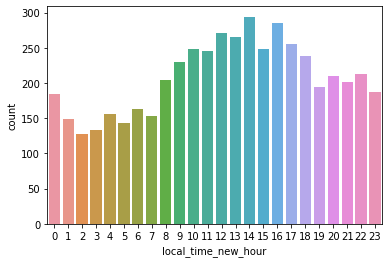

In [852]:
# math_submissions_removed: convert utc time to local time and see the distribution of post based on hour
math_submissions_removed = pd.read_csv('math_submissions_removed.csv')
test_math_submissions_removed = math_submissions_removed.copy()
test_math_submissions_removed['local_time_new'] = test_math_submissions_removed['created_utc'].map(lambda x:datetime.fromtimestamp(x))
test_math_submissions_removed['local_time_new_hour'] = test_math_submissions_removed['created_utc'].map(lambda x:datetime.fromtimestamp(x).hour)
sns.countplot(test_math_submissions_removed['local_time_new_hour']);

### Looks like the distribution is similar

---

### Prepare the submission data

In [742]:
def prepare(data_df):
    # combine title column and selftext column
    # check if the selftext is null and create a new column based on the result
    data_df['selftext_null'] = data_df['selftext'].isnull().astype(int)
    # using apply function to combine, if selftext is null then return title, otherwise, combine them.
    data_df['title_selftext'] = data_df.apply(lambda x: x['title'] if (x['selftext_null']==1) else (x['title']+x['selftext']),axis=1)
    
    # tokenize the title_selftext
    regex_token = RegexpTokenizer('\w+')
    data_df['title_selftext_token'] = data_df['title_selftext'].map(lambda x: regex_token.tokenize(x.lower()))
    
    # lemmitize the title_selftext_token
    lemmatizer = WordNetLemmatizer()
    data_df['title_selftext_token'] = data_df['title_selftext_token'].map(lambda x:[lemmatizer.lemmatize(i) for i in x])
    
    # convert list back to sting in order to CountVectorizer
    data_df['title_selftext_new'] = data_df['title_selftext_token'].map(lambda x: ','.join(x))
    
    return data_df
    

In [753]:
math_submissions = prepare(math_submissions)

In [754]:
physics_submissions = prepare(physics_submissions)

### Combine Math and Physics

In [847]:
# combine 2 datasets

data_1 =  pd.concat([math_submissions[['title_selftext_new','subreddit']],physics_submissions[['title_selftext_new','subreddit']]],axis=0,ignore_index=True)

In [756]:
X_1 = data_1['title_selftext_new']
y_1 = data_1['subreddit']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=42, stratify=y_1)

### Prepare the removed posts data

In [854]:
# since the selftext in removed posts is ['removed'], change it to nan
math_submissions_removed['selftext'] = np.nan

In [855]:
math_submissions_removed = prepare(math_submissions_removed)

In [872]:
# change the values in subreddit column to removed
math_submissions_removed['subreddit'] = 'removed'

In [875]:
data_2 =  pd.concat([math_submissions[['title_selftext_new','subreddit']],math_submissions_removed[['title_selftext_new','subreddit']]],axis=0,ignore_index=True)

In [858]:
X_2 = data_2['title_selftext_new']
y_2 = data_2['subreddit']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=42, stratify=y_2)

---
## 1st model: Logistic Regression

In [462]:
pipe_1 = Pipeline([('tvec', TfidfVectorizer()),
                  ('logreg', LogisticRegression())])

In [488]:
# pipe_1.get_params()

In [490]:
pipe_1_params = {
    'tvec__min_df':[2],
    'tvec__max_features':[6000,7000,8000],
    'tvec__stop_words':['english',None],
    'logreg__C':[1.3,1.35]
}

In [491]:
pipe_1_gs = GridSearchCV(pipe_1,pipe_1_params,cv=5,verbose=1)

In [492]:
pipe_1_gs.fit(X_train_1,y_train_1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [1.3, 1.35],
                         'tvec__max_features': [6000, 7000, 8000],
                         'tvec__min_df': [2],
                         'tvec__stop_words': ['english', None]},
             verbose=1)

In [493]:
pipe_1_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=6000, min_df=2,
                                 stop_words='english')),
                ('logreg', LogisticRegression(C=1.3))])

In [494]:
pipe_1_gs.best_score_

0.8765333333333334

In [735]:
pipe_1_gs.score(X_train_1,y_train_1),pipe_1_gs.score(X_test_1,y_test_1)

(0.9326666666666666, 0.8824)

### 2nd Model: Random Forest

In [648]:
pipe_2 = Pipeline([('tvec',TfidfVectorizer()),
                   ('rf',RandomForestClassifier(n_jobs=-1))])

In [649]:
# pipe_2.get_params()

In [651]:
pipe_2_params = {
#     'tvec__min_df':[1,2,3],
    'tvec__max_features':[3000,4000],
    'tvec__stop_words':['english'],
#     'tvec__ngram_range':[(1,1),(2,2)],
    'rf__n_estimators':[800,900]
#     'rf__max_depth':[None,3,5],
#     'rf__min_samples_leaf':[1,2]
}

In [652]:
pipe_2_gs = GridSearchCV(pipe_2,pipe_2_params,cv=5,verbose=1)

In [653]:
pipe_2_gs.fit(X_train_1,y_train_1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'rf__n_estimators': [800, 900],
                         'tvec__max_features': [3000, 4000],
                         'tvec__stop_words': ['english']},
             verbose=1)

In [654]:
pipe_2_gs.score(X_train_1,y_train_1)

0.9837333333333333

In [655]:
pipe_2_gs.score(X_test_1,y_test_1)

0.8652

In [883]:
# pipe_2_gs.best_estimator_

### 2.1 AdaBoost

In [540]:
pipe_2_1 = Pipeline([('tvec',TfidfVectorizer()),
                   ('ad',AdaBoostClassifier())])

In [563]:
pipe_2_1_params = {
    'tvec__max_features':[5000],
    'tvec__stop_words':['english'],
    'ad__base_estimator':[DecisionTreeClassifier(max_depth=2)],
    'ad__learning_rate':[0.1],
    'ad__n_estimators':[500]
                   }

In [564]:
pipe_2_1_gs = GridSearchCV(pipe_2_1,pipe_2_1_params,cv=5,verbose=1,n_jobs=-1)

In [565]:
pipe_2_1_gs.fit(X_train_1,y_train_1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ad', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'ad__base_estimator': [DecisionTreeClassifier(max_depth=2)],
                         'ad__learning_rate': [0.1], 'ad__n_estimators': [500],
                         'tvec__max_features': [5000], 'tvec__min_df': [1, 2],
                         'tvec__stop_words': ['english']},
             verbose=1)

In [629]:
# score for training data
pipe_2_1_gs.score(X_train_1,y_train_1)

0.9142666666666667

In [676]:
# score for testing data
pipe_2_1_gs.score(X_test_1,y_test_1)

0.8432

In [569]:
pipe_2_1_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('ad',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                    learning_rate=0.1, n_estimators=500))])

### Model 3.2. Predict Removed Posts

In [624]:
pipe_3_2 = Pipeline([('tvec', TfidfVectorizer()),
                  ('logreg', LogisticRegression(n_jobs=-1))])

pipe_3_2_params = {
#     'tvec__min_df':[1,2],
    'tvec__max_features':[3000,5000,6000,7000],
    'tvec__stop_words':['english'],
    'logreg__C':[1,2,3]
}

pipe_3_2_gs = GridSearchCV(pipe_3_2,pipe_3_2_params,cv=5,verbose=1)

In [625]:
pipe_3_2_gs.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'logreg__C': [1, 2, 3],
                         'tvec__max_features': [3000, 5000, 6000, 7000],
                         'tvec__stop_words': ['english']},
             verbose=1)

In [626]:
pipe_3_2_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('logreg', LogisticRegression(C=2, n_jobs=-1))])

In [627]:
pipe_3_2_gs.score(X_train_2,y_train_2)

0.8509333333333333

In [628]:
pipe_3_2_gs.score(X_test_2,y_test_2)

0.7568

### 3rd Model: SVM

In [669]:
pipe_3 = Pipeline([('tvec',TfidfVectorizer()),
                   ('svm',SVC())])

In [670]:
pipe_3_params = {
    'tvec__min_df':[1,2,3],
    'tvec__max_features':[None,4000,5000],
    'tvec__ngram_range':[(1,1),(2,2)],
    'svm__kernel':['rbf','poly'],
    'svm__C':[0.1,1,10]
}

In [671]:
pipe_3_gs = GridSearchCV(pipe_3,pipe_3_params,cv=5,verbose=2)

In [673]:
# pipe_3_gs.fit(X_train_1,y_train_1)

In [529]:
pipe_3_gs.best_estimator_

Pipeline(steps=[('tvec', TfidfVectorizer()), ('svm', SVC(C=1))])

In [532]:
pipe_3_gs.score(X_train_1,y_train_1)

0.98

In [533]:
pipe_3_gs.score(X_test_1,y_test_1)

0.8844

## Evaluating models

In [837]:
# calculate the precision and recall for 3 models
def precision_recall(X_test, y_true):
    preds_1 = pipe_1_gs.predict(X_test)
    preds_2 = pipe_2_gs.predict(X_test)
    preds_2_1 = pipe_2_1_gs.predict(X_test)
#     preds_3 = pipe_3_gs.predict(X_test_1)
    
    model_1 = ['Logistic Regression', precision_score(y_true,preds_1,pos_label='math'), recall_score(y_true,preds_1,pos_label='math')]
    model_2 = ['Random Forest', precision_score(y_true,preds_2,pos_label='math'), recall_score(y_true,preds_2,pos_label='math')]
    model_2_1 = ['Adaboost', precision_score(y_true,preds_2_1,pos_label='math'), recall_score(y_true,preds_2_1,pos_label='math')]

    result = pd.DataFrame([model_1,model_2,model_2_1],columns=['Model','Precision','Recall']).set_index('Model')
    return result

In [838]:
precision_recall(X_test_1,y_test_1)

,Precision,Recall
Model,,
Logistic Regression,0.866564,0.9040
Random Forest,0.832969,0.9136
Adaboost,0.793033,0.9288


In [879]:
# random pick some 100 data from each subreddit at a given time and return the precision and recall of each model
# in the example bettwen, choosed 2 time periods

def evaluate_models():
    random.seed(42)
    # 11/24/2020 - 3/29/2021
    random_time_1 = random.choice(range(1606228102,1617024502))
    
    math_1 = get_submissions('math',1,random_time_1)
    physics_1 = get_submissions('Physics',1,random_time_1)
    
    math_1 = prepare(math_1)
    physics_1 = prepare(physics_1)
    
    data_1 =  pd.concat([math_1[['title_selftext_new','subreddit']],physics_1[['title_selftext_new','subreddit']]],axis=0,ignore_index=True)
    X_1 = data_1['title_selftext_new']
    y_1 = data_1['subreddit']
    
    # 3/1/2015 - 9/1/2015
    random_time_2 = random.choice(range(1425220102,1441114102))
    
    math_2 = get_submissions('math',1,random_time_2)
    physics_2 = get_submissions('Physics',1,random_time_2)
    
    math_2 = prepare(math_2)
    physics_2 = prepare(physics_2)
    
    data_2 =  pd.concat([math_2[['title_selftext_new','subreddit']],physics_2[['title_selftext_new','subreddit']]],axis=0,ignore_index=True)
    X_2 = data_2['title_selftext_new']
    y_2 = data_2['subreddit']

    df_1 = precision_recall(X_1,y_1)
    df_2 = precision_recall(X_2,y_2)
    
    return df_1,df_2


In [880]:
period_1 ,period_2 = evaluate_models()

In [881]:
period_1

,Precision,Recall
Model,,
Logistic Regression,0.888889,0.96
Random Forest,0.934579,1.00
Adaboost,0.843478,0.97


In [882]:
period_2

,Precision,Recall
Model,,
Logistic Regression,0.923077,0.96
Random Forest,0.834783,0.96
Adaboost,0.770492,0.94
